### Simulate LP Activity using GBM
* https://medium.com/@chiqing/uniswap-v2-explained-beginner-friendly-b5d2cb64fe0f

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/research/impermanent_loss","")
os.chdir(cwd)

from python.dev.cpt import SolveDeltas
from python.dev.math.model import BrownianModel
from python.dev.cpt import Liquidity
from python.dev.cpt import LiquidityPoolUSD
from python.dev.math.model import EventSelectionModel
from python.dev.math.model import TokenDeltaModel

In [2]:
from python.dev.simulation import SimulateLiquidity
from python.dev.simulation import SimLPFees

**Simulate prices**

chg-mu 27.151% chg-sig 9.546%


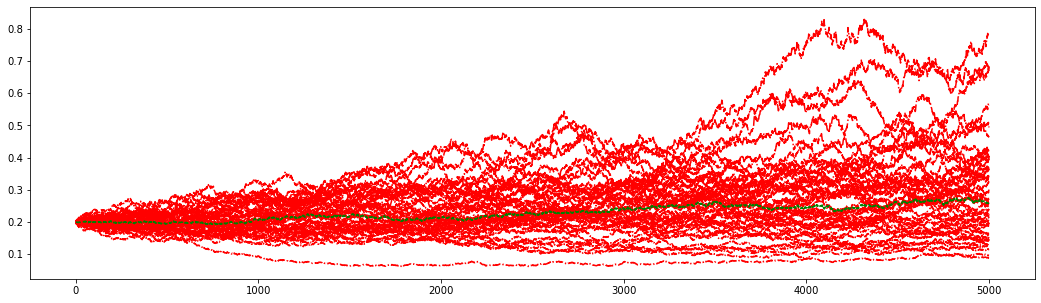

In [3]:
n_steps = 5000
start_price = 0.2
#mu = 0.4; sigma = 0.5
mu = 0.4; sigma = 0.5
n_paths = 50

b = BrownianModel(start_price)
p_arr = b.gen_gbms(mu, sigma, n_steps, n_paths)
exp_p_arr = np.median(p_arr, axis = 1)

x_val = np.arange(0,len(p_arr))
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
USD_ax.plot(p_arr, color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.plot(exp_p_arr, color = 'g',linestyle = 'dashed', label='initial invest') 

per_chg_sig = 100*np.sqrt(np.var(p_arr))
per_chg_mu = 100*(exp_p_arr[-1]-exp_p_arr[0])/exp_p_arr[0]
print('chg-mu {:.3f}% chg-sig {:.3f}%'.format(per_chg_mu, per_chg_sig))

**Calculate LP holdings using simulated prices**

In [4]:
lp_sims = {}
tdel = TokenDeltaModel(10000) 

for k in range(n_paths):
    liq = Liquidity(100000, 20000, 'SYS','DIA')
    simLiq = SimulateLiquidity(liq, tdel)
    #simLiq.run(p_arr[:,k], lp_rate = 0.55)
    simLiq.run(p_arr[:,k])
    simLiq.check(p_arr[:,k], 1000)
    lp_sims[k] = {}
    lp_sims[k]['sim_liq'] = simLiq  

raw: 0.1992113 y/x: 0.1992049 dy/dx: 0.2029638 liq: 44813.9085049
raw: 0.2452783 y/x: 0.2452018 dy/dx: 0.2445874 liq: 44822.4197875
raw: 0.1864061 y/x: 0.1864195 dy/dx: 0.1883249 liq: 44806.4073556
raw: 0.1917001 y/x: 0.1917055 dy/dx: 0.1905858 liq: 44821.6993767
raw: 0.1721847 y/x: 0.1722199 dy/dx: 0.1731654 liq: 44816.8595911
raw: 0.2897265 y/x: 0.2895822 dy/dx: 0.2851490 liq: 44819.6587627
raw: 0.2183724 y/x: 0.2183368 dy/dx: 0.2171696 liq: 44834.3441012
raw: 0.1906217 y/x: 0.1906278 dy/dx: 0.1931496 liq: 44824.1460589
raw: 0.2286652 y/x: 0.2286144 dy/dx: 0.2282560 liq: 44813.0931374
raw: 0.2224149 y/x: 0.2223743 dy/dx: 0.2217227 liq: 44803.4396069
raw: 0.2711173 y/x: 0.2710018 dy/dx: 0.2686068 liq: 44819.0621102
raw: 0.0932605 y/x: 0.0934156 dy/dx: 0.0936027 liq: 44817.5679028
raw: 0.2207211 y/x: 0.2206820 dy/dx: 0.2191996 liq: 44813.9300619
raw: 0.2826595 y/x: 0.2825267 dy/dx: 0.2801416 liq: 44808.8534000
raw: 0.1576707 y/x: 0.1577278 dy/dx: 0.1567997 liq: 44819.7627667
raw: 0.205

**Determine valuations from LP position**

In [5]:
start_pt = 0
init_pos_sys = 10000
init_pos_dai = p_arr[start_pt,0]*init_pos_sys

for k in range(n_paths):
    simLiq = lp_sims[k]['sim_liq']
    sys_arr = simLiq.get_x_arr()
    dai_arr = simLiq.get_y_arr()

    lpVal = LiquidityPoolUSD(sys_arr, dai_arr, p_arr[:,k])
    lp_sims[k]['lp_val'] = lpVal
    lp_sims[k]['hodl_usd'] = lpVal.hodl_position_usd(init_pos_sys, init_pos_dai, start_pt)
    lp_sims[k]['lp_pos'] = lpVal.lp_position_usd(init_pos_sys, init_pos_dai, start_pt)


**Determine collected fees from LP position**

In [6]:
for k in range(n_paths):
    simLiq = lp_sims[k]['sim_liq']
    lpVal = lp_sims[k]['lp_val']
    
    dai_arr = simLiq.get_y_arr()
    
    simFees = SimLPFees(simLiq, lpVal)
    lp_pos_fees = simFees.lp_position_fees_usd(init_pos_sys, init_pos_dai, start_pt)
    percent_returns = simFees.position_percent_returns(init_pos_sys, init_pos_dai, start_pt)
    
    lp_sims[k]['lp_pos_fees'] = lp_pos_fees
    lp_sims[k]['percent_returns'] = percent_returns
    
    print('percent returns: {:.3f}%'.format(100*percent_returns[-1]))
    print('collected fees:  ${:.2f}\n'.format(lp_pos_fees[-1]))
    

percent returns: 2.380%
collected fees:  $95.20

percent returns: 2.300%
collected fees:  $92.00

percent returns: 2.066%
collected fees:  $82.66

percent returns: 2.150%
collected fees:  $86.01

percent returns: 2.022%
collected fees:  $80.89

percent returns: 2.322%
collected fees:  $92.88

percent returns: 2.081%
collected fees:  $83.24

percent returns: 2.283%
collected fees:  $91.32

percent returns: 2.450%
collected fees:  $97.99

percent returns: 2.542%
collected fees:  $101.69

percent returns: 2.400%
collected fees:  $96.00

percent returns: 1.429%
collected fees:  $57.14

percent returns: 2.224%
collected fees:  $88.96

percent returns: 2.504%
collected fees:  $100.16

percent returns: 2.450%
collected fees:  $97.99

percent returns: 2.533%
collected fees:  $101.33

percent returns: 2.019%
collected fees:  $80.78

percent returns: 2.328%
collected fees:  $93.13

percent returns: 2.521%
collected fees:  $100.85

percent returns: 2.452%
collected fees:  $98.08

percent returns:

**Plots**

In [7]:
per_returns = np.zeros((n_steps, n_paths), np.float64)
lp_pos_fees = np.zeros((n_steps, n_paths), np.float64)
lp_pos = np.zeros((n_steps, n_paths), np.float64)
tot_lp_pos = np.zeros((n_steps, n_paths), np.float64)
hodl_usd = np.zeros((n_steps, n_paths), np.float64)
for k in range(0, n_paths):
    per_returns[:,k] = lp_sims[k]['percent_returns']
    lp_pos_fees[:,k] = lp_sims[k]['lp_pos_fees']
    hodl_usd[:,k] = lp_sims[k]['hodl_usd'][1:]
    lp_pos[:,k] = lp_sims[k]['lp_pos'][1:]
    tot_lp_pos[:,k] = lp_pos[:,k] + lp_pos_fees[:,k]

In [8]:
exp_per_returns = np.mean(per_returns, axis = 1)
exp_lp_pos = np.mean(lp_pos, axis = 1)
exp_hodl_usd = np.mean(hodl_usd, axis = 1)
exp_tot_lp_pos = np.mean(tot_lp_pos, axis = 1)
exp_lp_pos_fees = np.mean(lp_pos_fees, axis = 1)

In [9]:
def trading_fees(alpha, t):
    return t*alpha

def imp_loss_v2(per_mu, per_sigma, t, alpha):
    mu = 1*per_mu
    sigma = per_sigma
    return np.exp(-t*(sigma**2)/8 + trading_fees(alpha, t))/np.cosh(mu*t/2) - 1

### Trading Fees: Theoretical vs. Numerical

In [10]:
alpha = np.log(1+exp_per_returns[-1])
theoretical_trade_fees = trading_fees(alpha, 1)
numerical_trade_fees = exp_per_returns[-1]

print('Theoretical trading fees: {:.3f}%'.format(100*theoretical_trade_fees))
print('Numerical trading fees: {:.3f}%'.format(100*numerical_trade_fees))

Theoretical trading fees: 2.256%
Numerical trading fees: 2.282%


### Impermant Loss: Theoretical vs. Numerical

In [11]:
theoretical_IL = imp_loss_v2(mu, sigma, 1, 0)
numerical_IL = (exp_lp_pos[-1] - exp_hodl_usd[-1])/exp_hodl_usd[-1]

print('Theoretical impermanent loss: {:.3f}%'.format(100*theoretical_IL))
print('Numerical impermanent loss: {:.3f}%'.format(100*numerical_IL))

Theoretical impermanent loss: -4.983%
Numerical impermanent loss: -4.943%


### Total Gains: Theoretical vs. Numerical

In [13]:
theoretical_IL = imp_loss_v2(mu, sigma, 1, alpha)
numerical_IL = (exp_lp_pos[-1] + exp_lp_pos_fees[-1] - exp_hodl_usd[-1])/exp_hodl_usd[-1]

print('Theoretical gains/losses: {:.3f}%'.format(100*theoretical_IL))
print('Numerical gains/losses: {:.3f}%'.format(100*numerical_IL))

Theoretical gains/losses: -2.815%
Numerical gains/losses: -3.095%


Text(0.5, 0, 'Time')

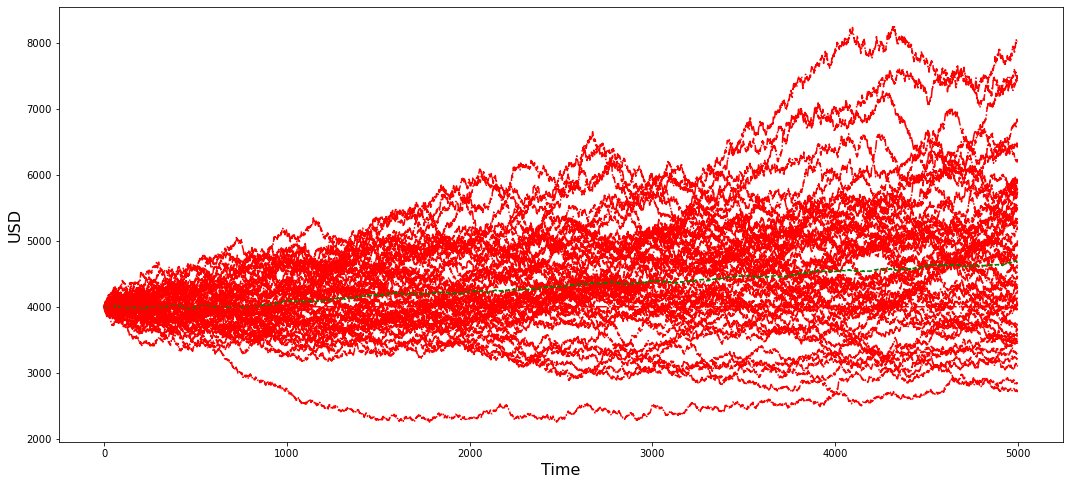

In [14]:
initial_usd = 2*init_pos_dai

fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 8))
USD_ax.plot(tot_lp_pos, color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.plot(exp_lp_pos, color = 'g',linestyle = 'dashed', label='initial invest') 
USD_ax.plot(np.repeat(initial_usd, n_steps), color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.set_xlabel('Time', fontsize=16)


Text(0.5, 0, 'Time')

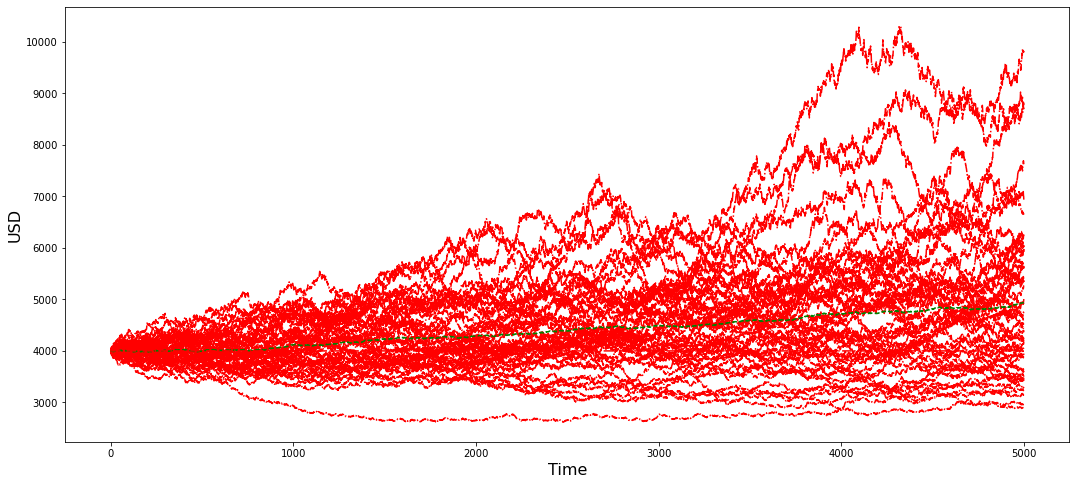

In [15]:
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 8))
USD_ax.plot(hodl_usd, color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.plot(exp_hodl_usd, color = 'g',linestyle = 'dashed', label='initial invest') 
USD_ax.plot(np.repeat(initial_usd, n_steps), color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.set_xlabel('Time', fontsize=16)


ValueError: x and y must have same first dimension, but have shapes (5000,) and (250050,)

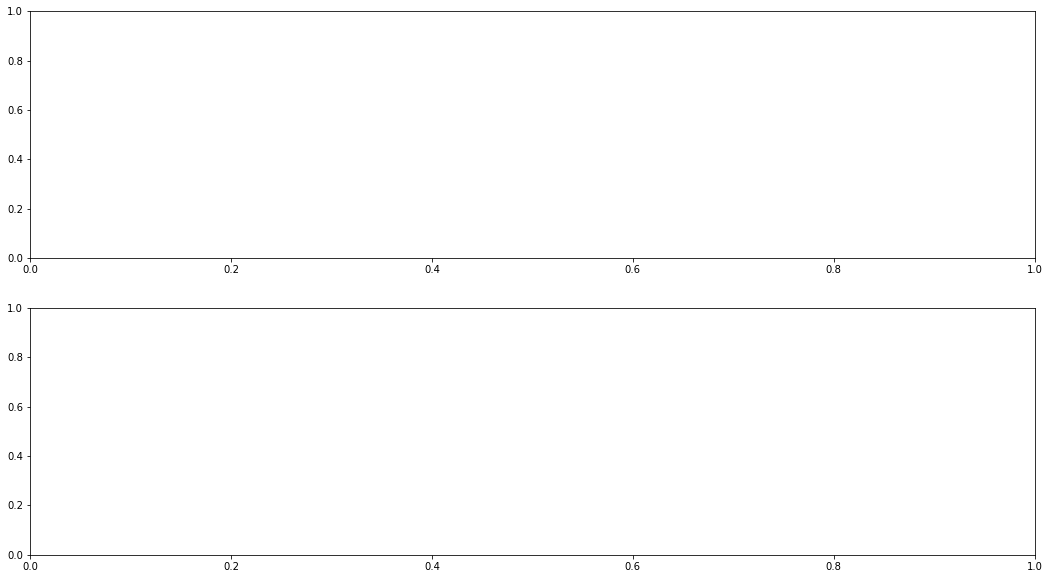

In [16]:
initial_usd = 2*p_arr[0]*init_pos_sys

x_val = np.arange(0,len(p_arr[1:,0]))
fig, (USD_ax, fee_ax) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(18, 10))
USD_ax.plot(x_val, np.repeat(initial_usd, len(p_arr)), color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.plot(x_val[1:], lp_pos[1:] + lp_pos_fees, color = 'g',label='lp invest + fees') 
USD_ax.plot(x_val[1:], lp_pos[1:], color = 'r',label='lp invest') 
USD_ax.set_title("Position: Value (USD)", fontsize=20)
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.set_xlabel('Time', fontsize=16)
USD_ax.legend()

fee_ax.plot(x_val[1:], lp_pos_fees, color = 'r',label='fees USD') 
fee_ax.set_title("Position: Collected Fees (USD)", fontsize=20)
fee_ax.set_ylabel("USD", fontsize=16)
fee_ax.set_xlabel('Time', fontsize=16)
fee_ax.legend()


In [ ]:
fig, (SYS_ax, DAI_ax, USD_ax, price_ax) = plt.subplots(nrows=4, sharex=False, sharey=False, figsize=(18, 20))
SYS_ax.plot(sys_arr, color = 'b',label='sys2') 
SYS_ax.set_title("USER1: LP Total (SYS)", fontsize=20)
SYS_ax.set_ylabel("SYS", fontsize=16)
SYS_ax.legend()

DAI_ax.plot(dai_arr, color = 'b',label='dai2') 
DAI_ax.set_title("USER1: LP Total (DAI)", fontsize=20)
DAI_ax.set_ylabel("DIA", fontsize=16)
DAI_ax.legend()

USD_ax.plot(usd_arr, color = 'b',label='usd2') 
USD_ax.set_title("USER1: LP Total (USD)", fontsize=20)
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.legend()

price_ax.plot(p_arr, label='price orig') 
price_ax.set_title("USER1: SYS_DAI_LP Prices", fontsize=20)
price_ax.set_ylabel("SYSDIA", fontsize=16)
price_ax.set_xlabel('Time', fontsize=16)
price_ax.legend()